In [83]:
import pandas as pd
import cobra
from copy import deepcopy
from cobra import Model, Reaction, Metabolite
from optlang.symbolics import add
from optlang.interface import OPTIMAL
import joblib
from joblib import Parallel, delayed
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Bigg metabolite metadata

In [ ]:
df_bigg_mets = pd.read_csv("Bigg/bigg_models_metabolites.txt", sep="\t")
df_bigg_mets.head()

,bigg_id,universal_bigg_id,name,model_list,database_links,old_bigg_ids
0,12dgr120_c,12dgr120,"1,2-Diacyl-sn-glycerol (didodecanoyl, n-C12:0)",iEC1364_W; iEC1349_Crooks; iEC1356_Bl21DE3; iM...,MetaNetX (MNX) Chemical: http://identifiers.or...,12dgr120; 12dgr120[c]; 12dgr120_c; _12dgr120_c
1,12dgr140_c,12dgr140,"1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)",iECNA114_1301; iECSE_1348; iECO111_1330; iECOK...,MetaNetX (MNX) Chemical: http://identifiers.or...,12dgr140; 12dgr140[c]; 12dgr140_c; _12dgr140_c
2,12dgr180_c,12dgr180,"1,2-Diacyl-sn-glycerol (dioctadecanoyl, n-C18:0)",iECB_1328; iECDH10B_1368; iEcE24377_1341; iECD...,MetaNetX (MNX) Chemical: http://identifiers.or...,12dgr180; 12dgr180[c]; 12dgr180_c; _12dgr180_c
3,14glucan_c,14glucan,"1,4-alpha-D-glucan",iSFxv_1172; iUTI89_1310; iSSON_1240; iSbBS512_...,BioCyc: http://identifiers.org/biocyc/META:1-4...,14glucan; 14glucan_c
4,15dap_c,15dap,"1,5-Diaminopentane",iECUMN_1333; iLF82_1304; iETEC_1333; iECSF_132...,KEGG Compound: http://identifiers.org/kegg.com...,15dap; 15dap[c]; 15dap_c


# Convert compound ID to Bigg ID

In [66]:
df_idconv = pd.read_csv("Data/han_nature_metabolites_metadata_w_biggids.csv")
df_idconv.head()

,dname,Compound,Peak,PubChem_CID,mz,rt,adduct,Molecular_formula_as_seen_in_ms,Monoisotopic_mass_as_seen_in_ms,Kingdom,Superclass,Class,Subclass,canonical_smiles,inchikey,mode,QE_rt,QE_ms2,qTOF_ms2,universal_bigg_id
0,m_c18n_0000,O-PHOSPHO-SERINE,NaN,106,184.001648,0.727,[M-H]-,C3H8NO6P,185.008924,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",C(C(C(=O)O)N)OP(=O)(O)O,BZQFBWGGLXLEPQ-UHFFFAOYSA-N,c18negative,NaN,NaN,NaN,NaN
1,m_c18n_0000,O-PHOSPHO-SERINE,NaN,68841,184.001648,0.727,[M-H]-,C3H8NO6P,185.008924,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",C(C(C(=O)O)N)OP(=O)(O)O,BZQFBWGGLXLEPQ-REOHCLBHSA-N,c18negative,0.666,*,*,NaN
2,m_c18n_0001,N-ACETYLTRYPTOPHAN,NaN,2002,245.093166,2.981,[M-H]-,C13H14N2O3,246.100442,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",CC(=O)NC(CC1=CNC2=CC=CC=C21)C(=O)O,DZTHIGRZJZPRDV-UHFFFAOYSA-N,c18negative,3.014,*,*,NaN
3,m_c18n_0001,N-ACETYLTRYPTOPHAN,NaN,439917,245.093166,2.981,[M-H]-,C13H14N2O3,246.100442,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",CC(=O)NC(CC1=CNC2=CC=CC=C21)C(=O)O,DZTHIGRZJZPRDV-GFCCVEGCSA-N,c18negative,3.053,*,*,NaN
4,m_c18n_0002,5-HYDROXYINDOLE,NaN,16054,132.045488,2.904,[M-H]-,C8H7NO,133.052764,Organic compounds,Organoheterocyclic compounds,Indoles and derivatives,Hydroxyindoles,C1=CC2=C(C=CN2)C=C1O,LMIQERWZRIFWNZ-UHFFFAOYSA-N,c18negative,2.978,*,*,NaN


# Bigg reaction pool

In [3]:
bigg = cobra.io.read_sbml_model("Bigg/bigg_universe_compartment_cpe.xml")
bigg.remove_reactions([bigg.reactions.St]) # it seems that this reaction (St) produces error in gapfill

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-01


No objective coefficients in model. Unclear what should be optimized


# Strain metadata

In [4]:
df_strain_meta = pd.read_csv('Data/han_nature_strain_metadata.csv')
df_strain_meta = df_strain_meta[df_strain_meta.source != "Not found"]
print("found %d strains with genomes."%(len(df_strain_meta)))
df_strain_meta.head()

found 167 strains with genomes.


,genome_id,taxonomy,NCBI organism name,NCBI strain name,NCBI assembly ID,source,cstr_num_total,cstr_num_used
0,G82,Clostridium aldenense WAL-18727 BEI HM-307,NaN,WAL-18727,NaN,De novo assembly of SRR058688 using SPAdes,29.0,21.0
1,G150,Muribaculum intestinale DSMZ 28989 YL27,NaN,DSM 28989,NaN,De novo assembly of SRR2124911 using SPAdes,NaN,NaN
2,G89,Clostridium cadaveris CC88A BEI HM-1041,NaN,CC88A,NaN,De novo assembly of SRR770200 using SPAdes,39.0,32.0
3,G10,Atopobium parvulum CC14Z BEI HM-1035,NaN,CC14Z,NaN,De novo assembly of SRR770242 using SPAdes,25.0,25.0
4,G88,Clostridium cadaveris CC44_001G BEI HM-1040,NaN,CC44_001G,NaN,De novo assembly of SRR770461 using SPAdes,50.0,5.0


# Metabolomics metadata (note that we have selected mega medium)

In [87]:
df_exp = pd.read_excel('Data/han_nature_metabolomics_peak_fc.xlsx', sheet_name='aggregated_md', engine='openpyxl', index_col=0)
df_exp.experiment = df_exp.experiment.astype(int)
df_exp.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,experiment,sample_type,media,subculture_time,preculture_time,c18positive,c18negative,hilicpositive,culture_source,taxonomy,grouped_taxonomy,kingdom,phylum,class,order,family,genus,species,strain,morphology
3,20181030,supernatant,pyg,16.00,30.0,s03081,s03182,s02980,c0082,Coprococcus sp. HPP0074 BEI HM-793,Coprococcus,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Coprococcus,NaN,HPP0074,NaN
4,20190228,media_blank,mm,17.25,NaN,s03818,s03658,s03513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20190228,media_blank,mm,17.25,NaN,s03819,s03659,s03514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,20190228,media_blank,mm,17.25,NaN,s03820,s03660,s03515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,20181030,supernatant,mm,12.00,30.0,s03029,s03130,s02928,c0206,Bacteroides thetaiotaomicron VPI 5482,Bacteroides thetaiotaomicron,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,thetaiotaomicron,NaN,NaN


# Ion count (index of this table is consistent with index of df_exp)

In [57]:
df_ion_count = pd.read_excel('Data/han_nature_metabolomics_peak_fc.xlsx', sheet_name='count.ps', engine='openpyxl', index_col=0)
df_ion_count.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,m_c18p_0000,m_c18p_0001,m_c18p_0003,m_c18p_0005,m_c18p_0006,m_c18p_0007,m_c18p_0008,m_c18p_0009,m_c18p_0011,m_c18p_0012,...,m_hilicp_0362,m_hilicp_0363,m_hilicp_0364,m_hilicp_0365,m_hilicp_0366,m_hilicp_0367,m_hilicp_0084,m_hilicp_0236,m_hilicp_0124,m_hilicp_0238
3,NaN,NaN,3583.768597,NaN,NaN,NaN,NaN,5.035858e+06,NaN,2.653437e+06,...,479035.978775,276592.521225,NaN,41038.392214,233168.813842,NaN,NaN,NaN,NaN,NaN
4,NaN,1142.775109,11818.167084,NaN,3233.358629,16915.774128,NaN,1.154907e+06,29604.535087,3.687761e+05,...,452616.451613,303012.048387,NaN,105044.781826,205241.380690,NaN,NaN,NaN,NaN,NaN
5,NaN,4872.896559,11251.867143,NaN,654.545044,19151.905278,NaN,1.279713e+06,34645.389755,3.875620e+05,...,436409.471516,319219.028484,NaN,110036.891872,205197.018787,NaN,NaN,NaN,NaN,NaN
6,NaN,5370.374879,9434.577663,NaN,2361.022460,19523.492976,NaN,1.247545e+06,36531.766097,3.997718e+05,...,444107.560519,311520.939481,NaN,109097.159177,209965.606554,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,6358.985415,NaN,NaN,NaN,NaN,1.170459e+06,NaN,2.429138e+05,...,470305.024965,285323.475035,NaN,122779.200978,270354.454475,NaN,NaN,NaN,NaN,NaN


# Metabolomics fold change

In [6]:
df_fc = pd.read_csv('Data/han_nature_log2fc_metabolites_w_biggid_stats.csv')
df_fc.head()

,genome_id,universal_bigg_id,media,n_reps,log2fc_mean,log2fc_var,log2fc_P,log2fc_Padj
0,G124,hom__L,mm,3,0.001837,0.000852,0.937202,0.947879
1,G124,gly,mm,3,-0.390934,0.003383,0.010889,0.026179
2,G124,ins,mm,3,0.258325,0.000304,0.002269,0.008534
3,G124,pala,mm,3,-0.248922,0.001139,0.009067,0.022890
4,G124,pro__L,mm,3,-0.054691,0.001453,0.179617,0.237555


# Growth rate (remove strains that do not grow at all)

In [102]:
df_growth = pd.read_csv("Data/han_nature_computed_max_growth_rate.csv")
df_growth = df_growth[df_growth.max_growth > 0]
df_growth.head()

,sample_id,taxonomy,experiment,od_loc_well,preculture_date,preculture_time,subculture_time,media,max_growth,r2
1,od00002,Bacteroides eggerthii DSMZ 20697,20180512.0,A02,20180512,24.0,NaN,mm,0.045154,0.984185
2,od00003,Bacteroides xylanoisolvens XB1A DSMZ 18836,20180512.0,A03,20180512,24.0,NaN,mm,0.088190,0.998253
3,od00004,Prevotella buccalis ATCC 35310,20180512.0,A04,20180512,24.0,NaN,mm,0.084855,0.998140
4,od00005,Bacteroides cellulosilyticus DSMZ 14838,20180512.0,A05,20180512,24.0,NaN,mm,0.045433,0.998794
5,od00006,Bacteroides theta VPI 5482,20180512.0,A06,20180512,24.0,NaN,mm,0.101122,0.999662


# Conversion from ion count to concentration

In [8]:
# read conversion between metabolite peak count and concentration relationship
df_lr = pd.read_excel('Data/han_nature_method_validation.xlsx', sheet_name='linear_range', engine='openpyxl')
df_lr = df_lr[['library_dname','m','b']].rename({'library_dname':'compound'}, axis=1) # ion count = 10^b * concentration^m, unit of concentration uM

# some compound has been measured multiple times, then average them
df_lr = df_lr.groupby('compound').agg(np.mean).reset_index()
assert len(df_lr) == len(set(df_lr.compound))

df_lr.head()

,compound,m,b
0,m_c18n_0002,1.147480,3.233167
1,m_c18n_0004,0.966178,4.270138
2,m_c18n_0005,0.909734,4.314900
3,m_c18n_0009,0.882238,4.145308
4,m_c18n_0010,0.845401,4.801475


# Gapfilling models

In [152]:
def gapfilling_by_metabolomics(genome_id, medium='mm', max_flux=1000.0, min_flux=0.01):
    
    # the gapfilled model exists
    #if os.path.exists("GSM_gapfilled_models/%s_gf.pickle"%(genome_id)):
    #    return 0
    
    # load culture medium
    df_mm = pd.read_csv('Medium/%s.tsv'%(medium), sep='\t')
    
    # load model
    model = cobra.io.read_sbml_model("GSM_carveme_draft/%s_carveme.xml"%(genome_id))
    model.solver = 'cplex'
    
    # make all internal exchange reactions open
    for ex in model.exchanges:
        ex.bounds = (-max_flux, max_flux)
    
    # get consumed and produced metabolites
    df2_fc = df_fc[(df_fc.log2fc_Padj<0.05) & (df_fc.genome_id==genome_id) & (df_fc.media==medium)]
    
    # add exchange reactions for all metabolites in culture medium
    # note that some compounds are not present in the culture medium but can be produced such as dad_5 (not sure how they calculate the fold change in this case)
    rxns2add = []
    for cpd in set(list(df_mm.compound)+list(df2_fc.universal_bigg_id)):
        if 'EX_%s_e'%(cpd) not in model.reactions:
            name = df_bigg_mets.loc[df_bigg_mets.universal_bigg_id==cpd, 'name']

            # create met_e and met_p if they do not exist
            met_e = Metabolite(
                    '%s_e'%(cpd),
                    name=name,
                    compartment='C_e')

            # add exchange reaction between environment and extracellular space
            reaction_ee = Reaction('EX_%s_e'%(cpd))
            reaction_ee.name = 'R_EX_%s_e'%(cpd)
            reaction_ee.subsystem = ''
            reaction_ee.gene_reaction_rule = ''
            reaction_ee.lower_bound = -1000.0
            reaction_ee.upper_bound =  1000.0
            reaction_ee.add_metabolites({met_e: -1.0})
            rxns2add.extend([reaction_ee])
    if len(rxns2add)>0:
        print('%d exchange reactions are added.'%(len(rxns2add)))
        model.add_reactions(set(rxns2add))
    assert model.slim_optimize()>0.0
    print(model.exchanges)

    # gapfilling for metabolites consumed and produced
    gapfilling_results = {}
    for bigg_id, log2fc_mean in zip(df2_fc.universal_bigg_id, df2_fc.log2fc_mean):
        model2 = deepcopy(model)
        if log2fc_mean < 0:
            # consumed
            model2.objective = -model2.reactions.get_by_id("EX_%s_e"%(bigg_id)).flux_expression
        else:
            # produced
            model2.objective =  model2.reactions.get_by_id("EX_%s_e"%(bigg_id)).flux_expression
        if model2.slim_optimize() < min_flux:
            print(bigg_id, "needs gapfilling.")
            # run gapfilling (one iteration)
            try:
                result = cobra.flux_analysis.gapfill(model2, universal=bigg, lower_bound=min_flux, demand_reactions=False, iterations=1)
                 # add gapfilled reactions
                model2.add_reactions(result[0])
                assert model2.slim_optimize() >= min_flux
                model = deepcopy(model2)
                print(model.exchanges)
                print("gapfilling succeeds for %s."%(bigg_id))
                gapfilling_results[bigg_id] = 1
            except:
                print("gapfilling fails for %s."%(bigg_id))
                gapfilling_results[bigg_id] = -1
        else:
            print("gapfilling not needed for %s."%(bigg_id))
            gapfilling_results[bigg_id] = 0
            
    cobra.io.write_sbml_model(model, "GSM_gapfilled_models/%s_gf.xml"%(genome_id))
    joblib.dump([model, gapfilling_results], "GSM_gapfilled_models/%s_gf.pickle"%(genome_id))
    return gapfilling_results

In [ ]:
_ = Parallel(n_jobs=-1)(delayed(gapfilling_by_metabolomics)(genome_id, medium='mm', max_flux=1000.0, min_flux=0.01) for genome_id in df_strain_meta.genome_id)

In [10]:
stats = []
for genome_id in df_strain_meta.genome_id:
    #print(genome_id)
    res = joblib.load('GSM_gapfilled_models/%s_gf.pickle'%(genome_id))
    df_res = pd.DataFrame.from_dict(res[1], orient='index').rename({0:'Count'}, axis=1)
    if len(df_res)==0:
        stats.append([genome_id, 0, np.NaN, np.NaN, np.NaN])
    else:
        stats.append([genome_id, len(df_res), len(df_res[df_res.Count==1]), len(df_res[df_res.Count==0]), len(df_res[df_res.Count==-1])])
df_stats = pd.DataFrame(stats, columns=['genome_id','sig_met','gf_needed_and_ok','gf_not_needed','gf_needed_but_fail']).set_index('genome_id')
df_stats.to_csv("Data/gapfilling_stats.csv")
df_stats.head()

,sig_met,gf_needed_and_ok,gf_not_needed,gf_needed_but_fail
genome_id,,,,
G82,28,19.0,9.0,0.0
G150,0,NaN,NaN,NaN
G89,38,24.0,10.0,4.0
G10,24,15.0,8.0,1.0
G88,50,34.0,10.0,6.0


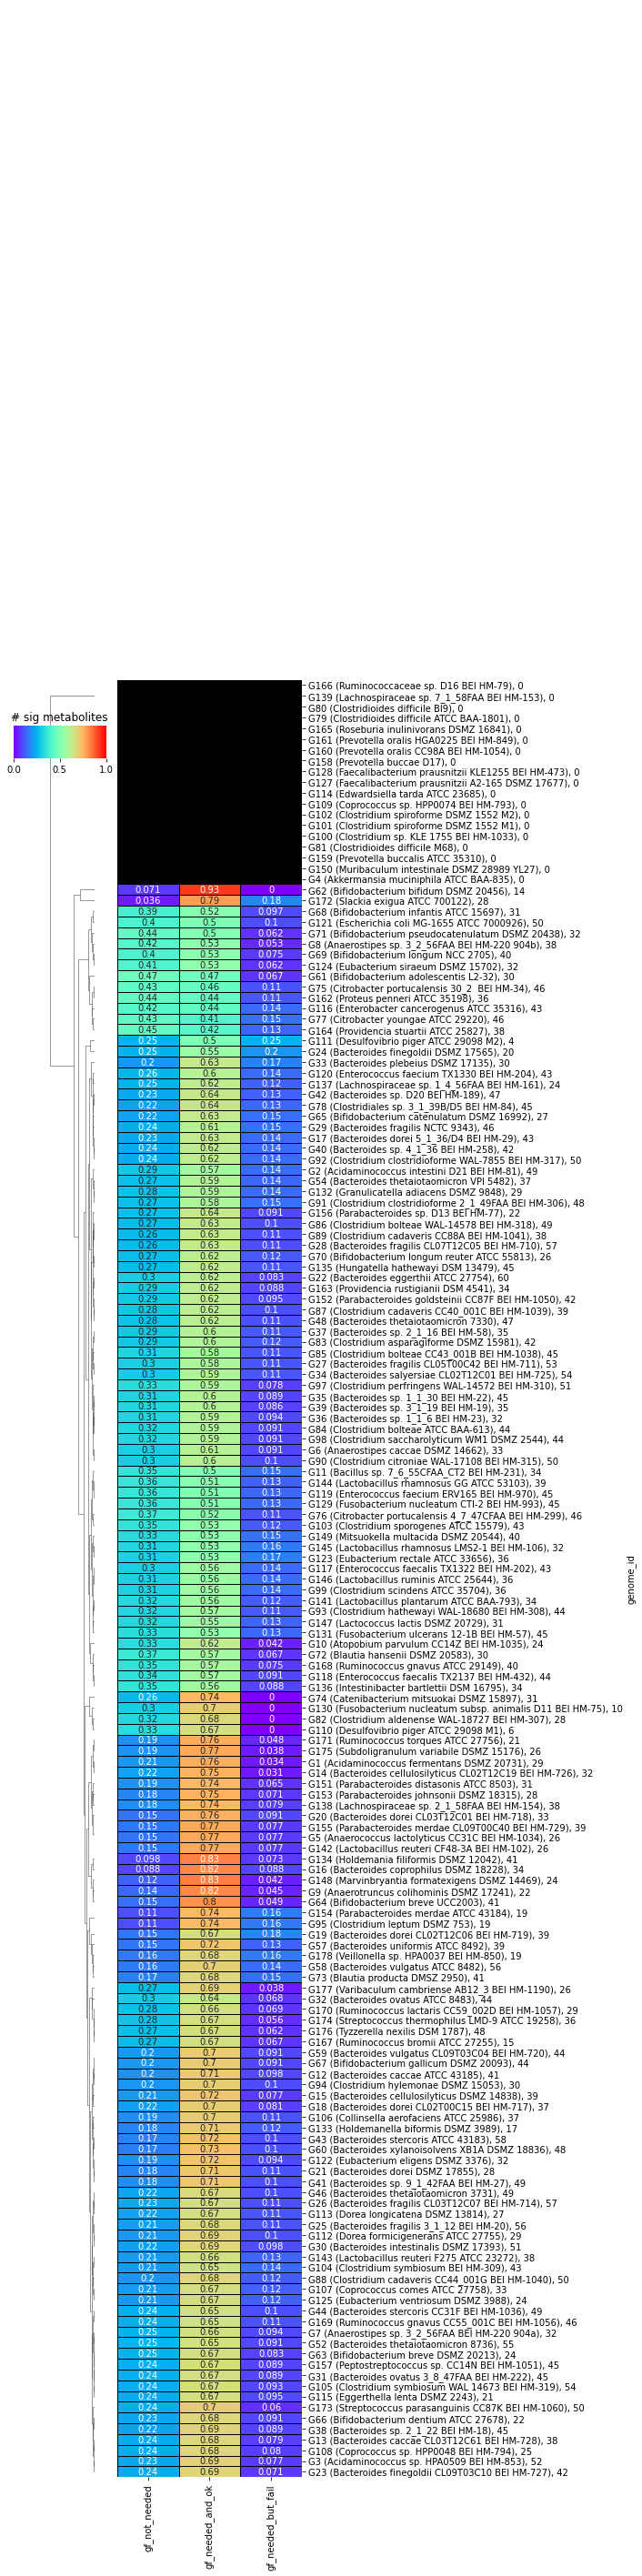

In [101]:
kws = dict(cbar_kws=dict(ticks=[0,0.5,1], orientation='horizontal'), annot=True)
df_stats_to_plot = df_stats.rename({x:'%s (%s), %d'%(x,y,z) for x,y,z in zip(df_strain_meta.genome_id, df_strain_meta.taxonomy, df_stats.loc[df_strain_meta.genome_id,'sig_met'])})
for col in ['gf_not_needed','gf_needed_and_ok','gf_needed_but_fail']:
    df_stats_to_plot[col] = df_stats_to_plot[col]/df_stats_to_plot['sig_met']
df_stats_to_plot = df_stats_to_plot[['gf_not_needed','gf_needed_and_ok','gf_needed_but_fail']]
g = sns.clustermap(
    data = df_stats_to_plot.fillna(0),
    figsize=(5,50),
    col_cluster=False,
    row_cluster=True,
    mask=df_stats_to_plot.isnull(),
    vmin=0,
    vmax=1,
    cmap='rainbow',
    linewidth=1,
    linecolor='k',
    **kws
)
x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([x0, 0.65, g.ax_row_dendrogram.get_position().width*2, 0.01])
g.ax_cbar.set_title('# sig metabolites')
g.ax_heatmap.xaxis.set_label_position('top')
g.ax_heatmap.set_facecolor('k')

plt.savefig('Figures/gapfilling_stats.png', dpi=300, bbox_inches = "tight")

# Find metabolic fluxes mostly consistent with experimental data

In [15]:
def find_solution(model):
    model.solver.problem.parameters.mip.tolerances.integrality.set(1e-9)
    try:
        solution = model.optimize(raise_error=False)
    except:
        print('first run:')
        print('optlang solver status: %s.' % (str(model.solver.status)))
        print('cplex solver status (%d): %s.'%(model.solver.problem.solution.get_status(), model.solver.problem.solution.get_status_string()))
    if model.solver.status != OPTIMAL: # get cplex return code: model2.solver.problem.solution.get_status()
        for method in ["primal","dual","network","barrier","sifting","concurrent"]:
            model.solver.configuration.lp_method = method
            if method != "sifting" and method != "concurrent":
                model.solver.configuration.qp_method = method
            try:
                solution = model.optimize(raise_error=False)
            except:
                print('LP/QP method: %s'%(method))
                print('optlang solver status: %s.' % (str(model.solver.status)))
                print('cplex solver status (%d): %s.'%(model.solver.problem.solution.get_status(), model.solver.problem.solution.get_status_string()))
            if model.solver.status == OPTIMAL:
                return model, solution
        if model.solver.status != OPTIMAL:
            return model, None
    else:
        return model, solution

In [109]:
def optimize_flux(model, genome_id, taxonomy, blank_conc=None, medium='mm', max_flux=1000.0, min_flux=0.01):
    
    model2 = deepcopy(model)
    
    #-------------------------------
    # Step 0: Constrain biomass flux
    #-------------------------------
    
    # get observed biomass flux
    # since we filter out strains that do not have growth rate, so here biomass flux must exist
    biomass_flux = list(df_growth.loc[(df_growth.taxonomy==taxonomy) & (df_growth.media==medium), 'max_growth'])
    assert len(biomass_flux)>0
    assert np.nanmin(biomass_flux)>0
    
    # get biomass reaction id
    biomass_rxn_ids = [rxn.id for rxn in model.reactions if "biom" in rxn.id.lower() or "growth" in rxn.id.lower()]
    assert len(biomass_rxn_ids)==1
    biomass_rxn_id = biomass_rxn_ids[0]
    
    # get consumed and produced metabolites
    model2.reactions.get_by_id(biomass_rxn_id).bounds = (np.nanmin(biomass_flux), np.nanmax(biomass_flux)) # constrain biomass flux

    #--------------------------------------------------------------------------------------------------------------------------
    # Step 1: Maximize the number of exchange reactions that carry flux if the corresponding metabolite changes are significant
    #--------------------------------------------------------------------------------------------------------------------------
    indicator_vars_sig_mets = []
    exchange_rxns_sig_mets = []
    df2_fc = df_fc[(df_fc.log2fc_Padj<0.05) & (df_fc.genome_id==genome_id) & (df_fc.media==medium)]
    for bigg_id, log2fc_mean in zip(df2_fc.universal_bigg_id, df2_fc.log2fc_mean):
        var = model2.problem.Variable('indicator_var_' + bigg_id, lb=0, ub=1, type='binary')
        exchange_rxns_sig_mets.append('EX_%s_e'%(bigg_id))
        indicator_vars_sig_mets.append(var)
        if log2fc_mean < 0:
            # flux <= max_flux * var - min_flux
            # if var = 0, flux <= -min_flux
            con = model2.problem.Constraint((model2.reactions.get_by_id("EX_%s_e"%(bigg_id)).flux_expression - max_flux * var).expand(),
                                           name = 'uptake_flux_constraint_' + bigg_id,
                                           ub=-min_flux)
        else:
            # flux >= -max_flux * var + min_flux
            # if var = 0, flux >= min_flux
            con = model2.problem.Constraint((model2.reactions.get_by_id("EX_%s_e"%(bigg_id)).flux_expression + max_flux * var).expand(),
                                           name = 'secretion_flux_constraint_' + bigg_id,
                                           lb=min_flux)
        model2.add_cons_vars([var,con])
        model2.solver.update()
                
    # minimize sum of indicator variables
    if len(indicator_vars_sig_mets)>0:
        model2.objective = add(*indicator_vars_sig_mets)
        model2.objective.direction = "min" 
        model2.solver.update()
        model2, solution_step1 = find_solution(model2)
        if solution_step1 is None:
            raise RuntimeError("All LP methods fail in Step 1. Exit.")
        print("Step 1 objective value = %2.1f."%(solution_step1.objective_value))    
    
        # add constraint to the total number of quantitative consistent positive reactions
        con = model2.problem.Constraint(add(*indicator_vars_sig_mets), name = 'n_qual_cons_pos_rxns', ub=solution_step1.objective_value+0.5)
        model2.add_cons_vars([con])
        model2.solver.update()
    else:
        print("Step 1 skipped.")
    
    #-------------------------------------------------------------------------------------------------------------------------------------
    # Step 2: Maximize the number of exchange reactions that do not carry flux if the corresponding metabolite changes are not significant
    #-------------------------------------------------------------------------------------------------------------------------------------
    
    # # constrain the fluxes based on the solutions
    # obj_value = 0
    # for ex in model.exchanges: # IMPORTANT: use model, not model2
    #     if ex.id in exchange_reactions_added:
    #         bigg_id = ex.id.split('EX_')[1].split('_e')[0]
    #         log2fc = list(df2_fc.loc[df2_fc.universal_bigg_id==bigg_id, 'log2fc_mean'])[0]
    #         var_primal = model2.variables['sig_met_fc_' + bigg_id].primal
    #         obj_value += var_primal
    #         assert var_primal == 0.0 or var_primal == 1.0
    #         if var_primal == 0.0:
    #             if log2fc < 0:
    #                 ex.bounds = (-max_flux, -min_flux)
    #             else:
    #                 ex.bounds = (min_flux, max_flux)
    #         else:
    #             # did it wrong
    #             print(ex.id)
    #             ex.bounds = (-max_flux, max_flux)

    # set indicator variables for import and export reactions
    indicator_vars_non_sig_mets = []
    exchange_rxns_non_sig_mets = []
    return model2
    print(model2)
    for ex in model2.exchanges:
        if ex.id not in exchange_rxns_sig_mets:
            bigg_id = ex.id.split('EX_')[1].split('_e')[0]
            var = model2.problem.Variable('indicator_var_' + bigg_id, lb=0, ub=1, type='binary')
            indicator_vars_non_sig_mets.append(var)
            con_u = model2.problem.Constraint((ex.flux_expression - max_flux * var).expand(),
                                             name = 'uptake_flux_constraint_' + bigg_id,
                                             ub=0)
            con_s = model2.problem.Constraint((ex.flux_expression + max_flux * var).expand(),
                                             name = 'secretion_flux_constraint_' + bigg_id,
                                             lb=0)
            model2.add_cons_vars([var,con_u,con_s])
            model2.solver.update()
    
    # minimize sum of indicator variables
    if len(indicator_vars_non_sig_mets)>0:
        model2.objective = add(*indicator_vars_non_sig_mets)
        model2.objective.direction = "min" 
        model2.solver.update()
        model2, solution_step2 = find_solution(model2)
        if solution_step2 is None:
            raise RuntimeError("All LP methods fail in Step 2. Exit.")
        print("Step 2 objective value = %2.1f."%(solution_step2.objective_value))    

        # add constraint to the total number of quantitative consistent negative reactions
        con = model2.problem.Constraint(add(*indicator_vars_non_sig_mets), name = 'n_qual_cons_neg_rxns', ub=solution_step2.objective_value+0.5)
        model2.add_cons_vars([con])
        model2.solver.update()
    else:
        print("Step 2 skipped.")
            
    #-------------------------------------------------------------------------------------------------------------------------------------
    # Step 3: identify the fluxes that maximize correlation with measured experimental data while maintaining the previous two constraints
    #-------------------------------------------------------------------------------------------------------------------------------------

    # # constrain fluxes based on solutions
    # for ex in model.exchanges: # IMPORTANT: use model, not model2
    #     if ex.id in exchange_rxns_non_sig_mets:
    #         bigg_id = ex.id.split('EX_')[1].split('_e')[0]
    #         var_primal = model2.variables['other_ex_var_' + bigg_id].primal
    #         assert var_primal == 0.0 or var_primal == 1.0
    #         if var_value == 0.0:
    #             ex.bounds = (0.0, 0.0)
    
    # set up objective function that maximize consistency between observed and predicted flux
    df3_fc = pd.merge(df2_fc, blank_conc, left_on='universal_bigg_id', right_on='universal_bigg_id', how='inner')
    if len(df3_fc)>0:
        df3_fc['concentration_supernatant'] = df3_fc['concentration_blank']*(2**(df3_fc.log2fc_mean))
        df3_fc['delta_concentration'] = df3_fc['concentration_supernatant']-df3_fc['concentration_blank']
        var_lin_coef = model2.problem.Variable('linear_coef', lb=0)
        model2.add_cons_vars([var_lin_coef])
        model2.solver.update()
        
        obj_vars = []
        for bigg_id, delta_conc in zip(df3_fc.universal_bigg_id, df3_fc.delta_concentration):
            obj_vars.append(((model2.reactions.get_by_id("EX_%s_e"%(bigg_id)).flux_expression-delta_conc)**2).expand())
        
        model2.objective = add(*obj_vars)
        model2.objective.direction = "min" 
        model2.solver.update()
        model2, solution_step3 = find_solution(model2)
        if solution_step3 is None:
            raise RuntimeError("All LP methods fail in Step 3. Exit.")
        print("Step 3 objective value = %2.1f."%(solution_step3.objective_value))    

        # add constraint to the total number of quantitative consistent negative reactions
        con = model2.problem.Constraint(add(*indicator_vars_non_sig_mets), name = 'n_qual_cons_neg_rxns', ub=solution_step2.objective_value+0.5)
        model2.add_cons_vars([con])
        model2.solver.update()
    else:
        print("Step 3 skipped.")
        
    return model2

#     model2 = deepcopy(model)
#     model2.reactions.get_by_id(biomass_rxn_id).upper_bound = np.nanmax(biomass_flux)
#     model2.objective = model2.reactions.get_by_id(biomass_rxn_id).flux_expression
#     model2.objective.direction = "max" 
#     model2.solver.update()
#     model2, solution = find_solution(model2, pFBA=True)
#     if solution is None:
#         raise RuntimeError("All LP methods fail. Exit.")
    
#     # constrain fluxes based on solutions
#     for ex in model.exchanges: # IMPORTANT: use model, not model2
#         flux = solution[ex.id]
#         if flux < 0.0:
#             ex.lower_bound = flux
#         else:
#             ex.lower_bound = max(float(ex.lower_bound), 0.0)
    
#     #print('pro__L lower bound', model.reactions.EX_pro__L_e.bounds)
#     print("Find pFBA solution finished. Obj = %2.2f."%(solution.objective_value))
    
#     #------------------- m,.
#     # Get final solution
#     #-------------------
#     model.objective = model.reactions.get_by_id(biomass_rxn_id).flux_expression
#     model.objective.direction = "max" 
#     model.solver.update()
#     model, solution = find_solution(model, pFBA=True)
            
#    return model, solution

In [110]:
for genome_id, tax in zip(df_strain_meta.genome_id, df_strain_meta.taxonomy):
    
    print(genome_id, tax)
    
    # if growth data is not available, then skip this model
    # we have filtered out experiments with growth rate equal to 0
    if tax not in list(df_growth[df_growth.media=='mm'].taxonomy):
        continue
    
    # find experimental days of experiments using this strain
    # if no information was found, try to use all media_blank
    exp_day = list(set(df_exp[(df_exp.taxonomy==tax) & (df_exp.media=='mm')].experiment))
    if len(exp_day) == 0:
        exp_day = list(set(df_exp[(df_exp.sample_type=='media_blank') & (df_exp.media=='mm')].experiment))
     
    # get concentration of metabolites in the blank media
    # standard curve: y=10**b * x**m where x is concentration (uM), y is ion count
    df_ion_count_tmp = deepcopy(df_count.loc[df_exp[(df_exp.experiment.isin(exp_day)) & (df_exp.sample_type=='media_blank') & (df_exp.media=='mm')].index])
    df_ion_count_tmp = df_ion_count_tmp.mean(skipna=True).to_frame().rename({0:'ion_count'}, axis=1)
    df_ion_count_tmp.index.name = 'compound'
    df_ion_count_tmp = df_ion_count_tmp.reset_index()
    df_ion_count_tmp = df_ion_count_tmp[df_ion_count_tmp.ion_count.notnull()] # remove metabolties in blank media that have undetected concentrations
    df_ion_count_tmp = pd.merge(df_ion_count_tmp, df_lr, left_on='compound', right_on='compound', how='left')
    df_ion_count_tmp = df_ion_count_tmp[(df_ion_count_tmp.m.notnull()) | (df_ion_count_tmp.b.notnull())] # some metabolites do not have a standard curve
    df_ion_count_tmp['concentration'] = (df_ion_count_tmp['ion_count']/10**df_ion_count_tmp['b'])**(1/df_ion_count_tmp['m'])
    df_ion_count_tmp = pd.merge(df_ion_count_tmp, df_idconv.rename({'dname':'compound'},axis=1)[['compound','universal_bigg_id']], left_on='compound', right_on='compound', how='left')
    df_ion_count_tmp = df_ion_count_tmp[df_ion_count_tmp.universal_bigg_id.notnull()]
    
    # some dnames are mapped to mulitple bigg ids, divide the concentration by the number that have 
    df_ion_count_tmp = pd.merge(
        df_ion_count_tmp,
        pd.DataFrame.from_dict(dict(Counter(df_ion_count_tmp.compound)), orient='index', columns=['group_size']).reset_index().rename({'index':'compound'},axis=1),
        left_on=['compound'],
        right_on=['compound'],
        how='left'
    )
    df_ion_count_tmp['concentration_blank'] = df_ion_count_tmp['concentration']/df_ion_count_tmp['group_size']
    df_ion_count_tmp = df_ion_count_tmp[['universal_bigg_id','concentration_blank']].groupby('universal_bigg_id').agg(np.sum).reset_index()
    
    # optimize flux
    unconstrained_model = joblib.load("GSM_gapfilled_models/%s_gf.pickle"%(genome_id))
    constrained_model = optimize_flux(unconstrained_model[0], genome_id, tax, blank_conc=df_ion_count_tmp, medium='mm', max_flux=1000.0, min_flux=0.01)
    assert 0

G82 Clostridium aldenense WAL-18727 BEI HM-307
Step 1 objective value = 2.0.


AssertionError: 

In [114]:
constrained_model.exchanges

AttributeError: 'Reaction' object has no attribute '_compartments'